# Практическое задание № 1. Классификация


**Работу выполнил (а):**

Мовчан Игорь 368540

# Распознавание активности человека на основе данных с мобильных сенсоров

Необходимо по данным с мобильных сенсоров при помощи прикладных алгоритмов машинного обучения предсказать активность человека по шести классам движений:
* Движется по прямой
* Движется вверх (например, движение по лестнице вверх)
* Движется вниз (например, движение по лестнице вниз)
* Сидит
* Стоит
* Лежит

## Сведения о наборе данных
Набор данных содержит записи датчиков со сматфонов (акселерометр и гироскоп с частотой дискретизации 50 Гц) от 30 участников, выполняющих следующие действия: ходьба, ходьба по лестнице, ходьба по лестнице, сидение, стояние и лежание. Данные были предварительно обработаны при помощи фильтров шума. Набор данных представлен Хорхе Л. Рейес-Ортисом.

Признаки были извлечены из 3-х осевых необработанных сигналов акселерометра и гироскопа tAcc-XYZ и tGyro-XYZ. Эти сигналы были сняты с постоянной частотой 50 Гц. Затем были отфильтрованны с помощью медианного фильтра и низкочастотного фильтра Баттерворта 3-го порядка с частотой 20 Гц для удаления шумов. Аналогичным образом сигнал ускорения был разделен на сигналы ускорения тела и гравитации (`tBodyAcc-XYZ` и `tGravityAcc-XYZ`) с помощью другого низкочастотного фильтра Баттерворта с угловой частотой 0,3 Гц. Линейное ускорение тела и угловая скорость были использованы для получения сигналов "рывка" — (`tBodyAccJerk-XYZ` и `tBodyGyroJerk-XYZ`). Также величина этих трехмерных сигналов была расчитана с использованием евклидовой нормы — (`tBodyAccMag`, `tGravityAccMag`, `tBodyAccJerkMag`, `tBodyGyroMag`, `tBodyGyroJerkMag`). 

Наконец, к некоторым из этих сигналов было применено быстрое преобразование Фурье (БПФ), в результате чего получились `fBodyAcc-XYZ`, `fBodyAccJerk-XYZ`, `fBodyGyro-XYZ`, `fBodyAccJerkMag`, `fBodyGyroMag`, `fBodyGyroJerkMag`. (Обратите внимание на "f" для обозначения сигналов в частотной области). 

Набор переменных, которые были оценены по этим сигналам, следующий: 
* mean(): Среднее значение
* std(): Стандартное отклонение
* mad(): Среднее абсолютное отклонение 
* max(): Наибольшее значение в массиве
* min(): Наименьшее значение в массиве
* sma(): Область величины сигнала
* energy(): Мера энергии. Сумма квадратов, деленная на количество значений. 
* iqr(): Интерквартильный размах 
* entropy(): Энтропия сигнала
* arCoeff(): Коэффициенты авторегрессии с порядком Burg, равным 4
* correlation(): коэффициент корреляции между двумя сигналами
* maxInds(): индекс частотной составляющей с наибольшей величиной
* meanFreq(): средневзвешенное значение частотных компонент для получения средней частоты
* skewness(): перекос сигнала в частотной области 
* kurtosis(): эксцесс сигнала в частотной области 
* bandsEnergy(): Энергия частотного интервала в пределах 64 бинов БПФ каждого окна.
* angle(): Угол между векторами.
## Импорт библиотек
Первым делом импортируем необходимые библиотеки для работы с данными:

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

sns.set(style="darkgrid")

## Считываем набор данных

В прикладных задачах машинного обучения очень важен процесс извлечения признаков (feature extraction), в ходе которого данные интерпретируются в информативные признаки. Также этот процесс может называться проектирование признаков (feature engineering), это весьма трудоемкая и творческая задача. В рамках работы мы опустим эту часть и воспользуемся предобработанными данными. 

In [2]:
def read_data(path, filename):
    return pd.read_csv(os.path.join(path, filename))

df = read_data("./", "train.csv")
df.shape

(7352, 563)

Теперь, загрузим полный набор данных и сохраним его под следующими четырьмя переменными:

* `train_x`: признаки, используемые для обучения модели
* `train_y`: метки, используемые для обучения модели
* `test_x`: признаки, используемые для проверки модели
* `test_y`: метки, используемые для проверки модели

In [3]:
def load_dataset(label_dict):
    train_x = read_data('./', 'train.csv').values[:,:-2]
    train_y = read_data('./', 'train.csv')['Activity']
    train_y = train_y.map(label_dict).values
    test_x = read_data('./', 'test.csv').values[:,:-2]
    test_y = read_data('./', 'test.csv')
    test_y = test_y['Activity'].map(label_dict).values
    return(train_x, train_y, test_x, test_y)

label_dict = {'WALKING':0, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':2, 'SITTING':3, 'STANDING':4, 'LAYING':5}
train_x, train_y, test_x, test_y = load_dataset(label_dict)

## Выбор модели

Для начала выберем уже знакомый нам из практической линейной алгебры метод k-ближайших. . На что влияют?

In [4]:
from sklearn.neighbors import KNeighborsClassifier

kn_model = KNeighborsClassifier()

В качестве гиперпараметров (характеристик модели до начала обучения) здесь выступают:
* `n_neighbors` (используется для подсчёта нового центра на каждом шаге, увеличивает быстродействие; по умолчанию = 5)
* `weights` (тип влияния каждой точки на подсчёт; изначально `uniform` - равное влияние, но может быть и `distance` - в зависимости от близости, `[callable]` - любая собственная функция влияния)
* `metric` (как понятно, для задания метрики, того, как вычисляется дистанция между векторами; по умолчанию - расстояние Минковского)

и прочие, что задают алгоритмы выбора либо параметры уже исходных характеристик. 

## Обучение модели

Обучим модель, используя признаки из обучающего набора (`train_x`) и метки в качестве базовой истины (`train_y`):

In [5]:
kn_model.fit(train_x, train_y)

KNeighborsClassifier()

## Оценка модели
Используя обученную модель для прогнозирования активности движения и признаки из тестового набора (`test_x`), сделаем прогнозы для тестовой выборки, сохраним в `predicted_y`:

In [6]:
predicted_y = kn_model.predict(test_x)

Проверим качество модели:

In [7]:
from sklearn.metrics import classification_report

target_names = ['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Sitting', 'Standing', 'Laying']

print(classification_report(test_y, predicted_y, target_names=target_names))

                    precision    recall  f1-score   support

           Walking       0.85      0.98      0.91       496
  Walking Upstairs       0.89      0.90      0.90       471
Walking Downstairs       0.95      0.79      0.86       420
           Sitting       0.91      0.79      0.85       491
          Standing       0.83      0.93      0.88       532
            Laying       1.00      0.99      1.00       537

          accuracy                           0.90      2947
         macro avg       0.91      0.90      0.90      2947
      weighted avg       0.91      0.90      0.90      2947



Здесь для проверки качества классификации используются разные характеристики:
* `precision` показывает, насколько часто мы ошибаемся, говоря, что имеем тот или иной класс
* `recall` отвечает за процент верно отнесённых к какому-то классу данных от общего числа данных этого класса
* `f1-score` комбинирует `precision` и `recall` в одну характеристику, показывающую общее качество нашей модели

Формула для вычисления `f1` с равным весом как `precision`, так и `recall`:
$$
    f_{1} = \frac{2*\text{precision}*\text{recall}}{\text{precision} + \text{recall}}
$$

Принимает значения от 0 до 1, а максимальное качество достигается при 1.

Наша модель здесь показала вполне неплохие результаты: все значения колеблются около 0.9, а это значит, что мы в 9 из 10 случаев попадаем туда, куда нужно.

Что ж попробуем изменить гиперпараметры!

## Изменение гиперпараметров

Что ж, попробуем поменять метрику на манхэттенскую и увеличить число соседей (не слишком сильно, так как это может ухудшить нашу модель):

In [8]:
kn_model_updated = KNeighborsClassifier(metric="cityblock", n_neighbors=10)

Обучим:

In [9]:
kn_model_updated.fit(train_x, train_y)

KNeighborsClassifier(metric='cityblock', n_neighbors=10)

И сравним:

In [10]:
predicted_y_updated = kn_model_updated.predict(test_x)
print(classification_report(test_y, predicted_y_updated, target_names=target_names))

                    precision    recall  f1-score   support

           Walking       0.86      0.98      0.92       496
  Walking Upstairs       0.88      0.91      0.89       471
Walking Downstairs       0.98      0.78      0.87       420
           Sitting       0.95      0.87      0.91       491
          Standing       0.89      0.96      0.92       532
            Laying       1.00      1.00      1.00       537

          accuracy                           0.92      2947
         macro avg       0.93      0.92      0.92      2947
      weighted avg       0.93      0.92      0.92      2947



## Сравнение

Визуализируем для большей наглядности:

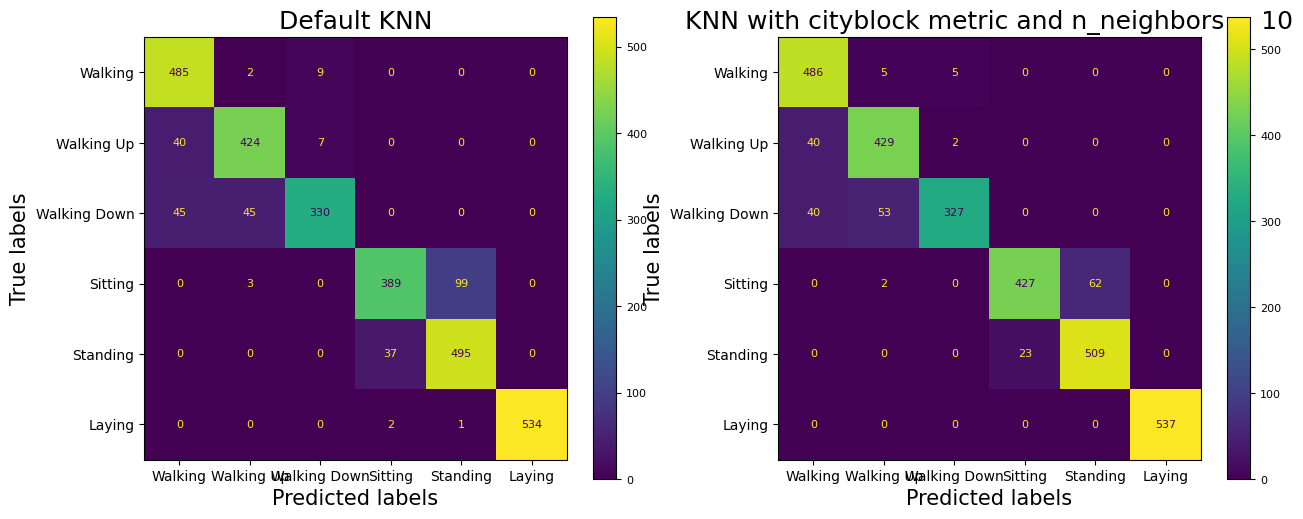

In [11]:
from sklearn import metrics
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
plt.rcParams.update({"font.size": 15})
ax[0].set_title("Default KNN")
ax[1].set_title("KNN with cityblock metric and n_neighbors = 10")
plt.rcParams.update({"font.size": 8})

labels = ['Walking', 'Walking Up', 'Walking Down', 'Sitting', 'Standing', 'Laying']

metrics.ConfusionMatrixDisplay(
    confusion_matrix=metrics.confusion_matrix(test_y, predicted_y),
    display_labels=labels,
).plot(ax=ax[0])


metrics.ConfusionMatrixDisplay(
    confusion_matrix=metrics.confusion_matrix(test_y, predicted_y_updated),
    display_labels=labels,
).plot(ax=ax[1])

label_font = {"size": "15"} 
ax[0].set_xlabel("Predicted labels", fontdict=label_font)
ax[0].set_ylabel("True labels", fontdict=label_font)
ax[1].set_xlabel("Predicted labels", fontdict=label_font)
ax[1].set_ylabel("True labels", fontdict=label_font)

plt.show()

Что ж, изменение гиперпараметров дало свои плоды, и качество стало чуть лучше. Жаль, что только чуть...

Видимо, стоит изменить модель на менее тривиальную!

## Меняем модель

Испробуем стандартную логистическую регрессию:

In [12]:
from sklearn.linear_model import LogisticRegression

regression = LogisticRegression()

Обучим:

In [13]:
regression.fit(train_x, train_y)

c:\Users\ventus\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

И проверим качество на тестовой выборке:

In [14]:
from sklearn.metrics import f1_score

regression_y = regression.predict(test_x)
print(round(f1_score(test_y, regression_y, average='weighted'), 3))

0.958


`f1_score` значительно возросло!

Попробуем теперь изменить гиперпараметры. Но для начала узнаем, что вообще можно изменять:
* `penalty` отвечает за регуляризацию, необходимая для предотвращения переобучения модели (параметр `l1` штрафует модель соотносительно всем весам, `l2` уделяет отдельное внимание большим, прислушиваясь к маленьким, `elasticnet` даёт своеобразную комбинацию всего этого); изначально - `l2`
* `c` - тот коэффициент, который стоит перед `penalty`; по умолчанию - 1.0
* `solver` используется для выбора алгоритма оптимизации (различные реализации используются для разного, так, `liblinear` хорош на маленьких выборках, `sag` и `saga` - для больших, а `newton-cg` и `lbfgs` для многоклассовых данных); по умолчанию - `lbfgs`

и прочее.

"Основной" гиперпараметр в нашем случае - `penalty`, попытаемся изменить его на `l1` и `elasticnet`, которые не поддерживает `lbfgs`, так что в качестве параметра `solver` используем `saga`:

In [15]:
regression_l1 = LogisticRegression(penalty='l1', solver='saga')
regression_elas = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.4)

`l1_ration` задаёт влияние регуляризации с помощью `l1`, чем ближе к 0 - тем более похожи на `l2`, чем больше - тем ближе к `l1`.

Обучим:

In [16]:
regression_l1.fit(train_x, train_y)

c:\Users\ventus\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(penalty='l1', solver='saga')

In [17]:
regression_elas.fit(train_x, train_y)

c:\Users\ventus\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(l1_ratio=0.4, penalty='elasticnet', solver='saga')

И получим её `f1-score`:

In [18]:
regression_y_l1 = regression_l1.predict(test_x)
print(round(f1_score(test_y, regression_y_l1, average='weighted'), 3))

regression_y_elas = regression_elas.predict(test_x)
print(round(f1_score(test_y, regression_y_elas, average='weighted'), 3))

0.959
0.961


А также визуализируем:

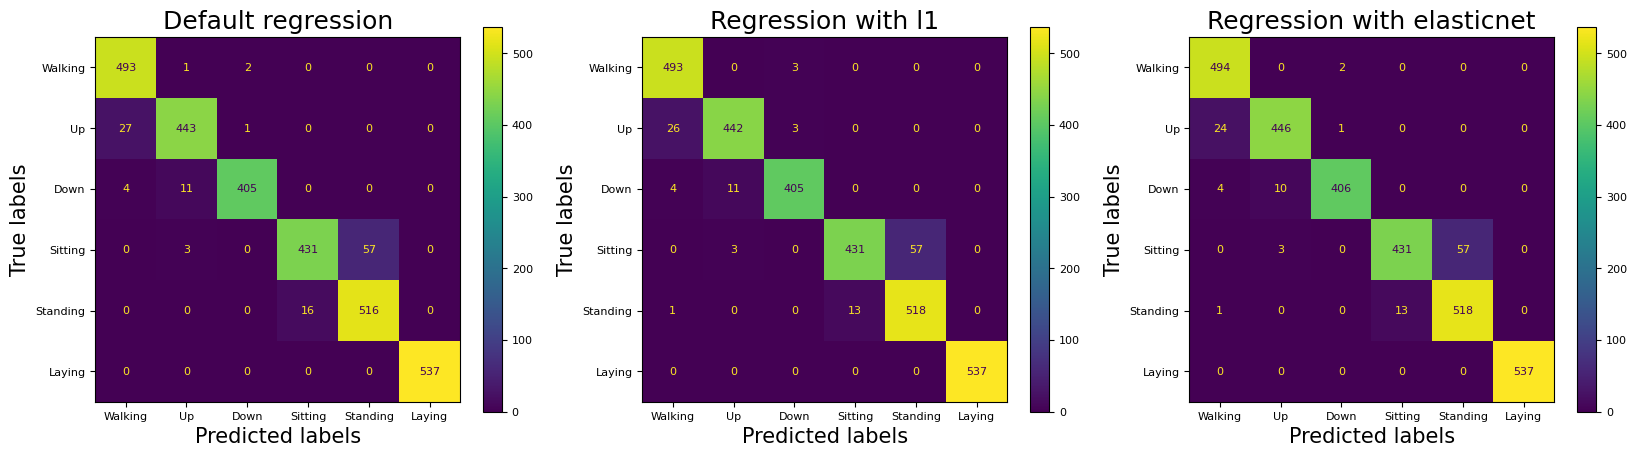

In [19]:
predicted = [regression_y, regression_y_l1, regression_y_elas]
titles = ["Default regression", "Regression with l1", "Regression with elasticnet"]
labels = ["Walking", "Up", "Down", "Sitting", "Standing", "Laying"]

fig, ax = plt.subplots(1, len(predicted), figsize=(20, 5))

for i in range(len(predicted)):
    plt.rcParams.update({"font.size": 15})
    ax[i].set_title(titles[i])
    plt.rcParams.update({"font.size": 8})

    metrics.ConfusionMatrixDisplay(
        confusion_matrix=metrics.confusion_matrix(test_y, predicted[i]),
        display_labels=labels,
    ).plot(ax=ax[i])

    label_font = {"size": "15"} 
    ax[i].set_xlabel("Predicted labels", fontdict=label_font)
    ax[i].set_ylabel("True labels", fontdict=label_font)

plt.show()

При таких значениях можем говорить, что разницы просто нет :)

## Деревья и леса

Говорят решающие деревья и случайные леса очень хороши в задачах классификации, проверим это на методе ансамблиевом методе случайного леса.

Здесь имеется множество гиперпараметров, начиная от глубины `max_depth` одного дерева, которая прямо пропорционально влияет на точность, и `criterion` для оценки качества сплита (определяет наилучшее разбиение объектов на подмножества, что прямо сказывается на обучении), заканчивая заданием состояния `random_state` для воспроизведения генерации после, но основным всё же является `criterion`, который по умолчанию установлен в `gini`.

In [20]:
from sklearn.ensemble import RandomForestClassifier

tree_classifier_gini = RandomForestClassifier()
tree_classifier_entropy = RandomForestClassifier(criterion='entropy')

Обучение:

In [21]:
tree_classifier_gini.fit(train_x, train_y)

RandomForestClassifier()

In [22]:
tree_classifier_entropy.fit(train_x, train_y)

RandomForestClassifier(criterion='entropy')

Проверим качество:

In [23]:
predicted_y_gini = tree_classifier_gini.predict(test_x)
print(classification_report(test_y, predicted_y_gini))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       496
           1       0.90      0.89      0.90       471
           2       0.96      0.84      0.90       420
           3       0.90      0.89      0.90       491
           4       0.90      0.91      0.91       532
           5       1.00      1.00      1.00       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



In [24]:
predicted_y_entropy = tree_classifier_entropy.predict(test_x)
print(classification_report(test_y, predicted_y_entropy))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       496
           1       0.89      0.90      0.89       471
           2       0.96      0.85      0.90       420
           3       0.94      0.88      0.91       491
           4       0.90      0.95      0.92       532
           5       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.92      0.93      2947
weighted avg       0.93      0.93      0.93      2947



Без изменений, на уровне метода KNN. Почему же так?

## Сравнение всех методов

В итоге лучше всех себя показала логистическая регрессия, дав f1-score = 0.96. Скорее всего, это возникло по причине высокой корреляции признаков между собой, а так как линейная регрессия в целом является более устойчивой в этом плане (если сравнивать, например, со случайным лесом), то она показала и более лучший результат.

На это указывает и количество высоких корреляций между всеми столбцами признаков:

In [74]:
corrmat = df.drop(columns=["Activity"]).corr()
high_corr_count = corrmat[(corrmat > 0.9) & (corrmat < 1)].count() // 2

In [75]:
sum(high_corr_count)

7570

Пример прямо показывает, что больше - не всегда лучше (даже хорошие методы классификации показывали лишь удовлетворительные результат). Для достижения выдающихся результатов необходимо было выделить действительно необходимые признаки (явно не 563 :)), мало коррелирующие между собой, и уже после этого применять методы машинного обучения.

На этом всё, спасибо за чтение!